In [1]:
import sys
sys.path.append('/content/drive/MyDrive/Uni/Deep Learning for Computer Vision/GeoGuessr_Project')

ROOT_DIR = r'C:\Users\Shadow\Pictures\Geogussr\Projekt'

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
#from torchsummary import summary
from torch.optim import lr_scheduler


# Dataset
from GeoGuessrDataset import GeoGuessrDataset


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tnrange
import time
import copy

%matplotlib inline

# Enable autoreloading of imported modules.
%load_ext autoreload
%autoreload 2

In [3]:

# Check GPU support on your machine.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)


cuda:0


In [4]:

# from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models.resnet import resnet50, ResNet50_Weights, resnet18, ResNet18_Weights


# New weights with accuracy 80.858%
resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# Best available weights (currently alias for IMAGENET1K_V2)
# Note that these weights may change across versions
resnet50(weights=ResNet50_Weights.DEFAULT)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
import pygeohash as phg

df = pd.read_csv(r"C:\Users\Shadow\Documents\DLCV_Project_GeoGuessr_AI-valdrin\preprocess\coordinates.csv", delimiter=',', skiprows=0, low_memory=False)

# We want a geohash precsion of 3 so that we get approximately 32768 cells, which will represent our classes.
df['geohash']=df.apply(lambda coords: phg.encode(coords.latitude, coords.longitude, precision=3), axis=1)


def geohash_to_decimal(geohash):
    base_32 = '0123456789bcdefghjkmnpqrstuvwxyz';
    geohash = geohash.lower()
    return sum([32**idx * base_32.index(char) for idx, char in enumerate(geohash[::-1])])

df['geohash_decimal']=df.apply(lambda x: geohash_to_decimal(x["geohash"]) ,axis=1)

geohashes_with_samples = df["geohash_decimal"].unique()
print("Number of geohashes with samples", len(geohashes_with_samples))



#save for mapping
#tensor = torch.tensor(geohashes_with_samples)
#torch.save(tensor,'mapgttohash.pt')
geohash_map = { geo: i for i, geo in enumerate(geohashes_with_samples)}


df["geo_code"] = df.apply(lambda geohash: geohash_map[geohash["geohash_decimal"]], axis=1)

df[["filename", "latitude","longitude", "geohash_decimal", "geo_code"]].to_csv(r"C:\Users\Shadow\Documents\DLCV_Project_GeoGuessr_AI-valdrin\preprocess\coordinates2.csv", index=False)

Number of geohashes with samples 3139


In [6]:


#df = pd.read_csv(r"F:\Users\basti\Documents\Goethe Uni\DLCV Projekt\coordinatesapi.csv", delimiter=',', skiprows=0, low_memory=False)

# We want a geohash precsion of 3 so that we get approximately 32768 cells, which will represent our classes.
#df['geohash']=df.apply(lambda coords: phg.encode(coords.latitude, coords.longitude, precision=3), axis=1)


#def geohash_to_decimal(geohash):
 #   base_32 = '0123456789bcdefghjkmnpqrstuvwxyz';
  #  geohash = geohash.lower()
   # return sum([32**idx * base_32.index(char) for idx, char in enumerate(geohash[::-1])])

#df['geohash_decimal']=df.apply(lambda x: geohash_to_decimal(x["geohash"]) ,axis=1)

#geohashes_with_samples = df["geohash_decimal"].unique()
#print("Number of geohashes with samples", len(geohashes_with_samples))


#df["geo_code"] = df.apply(lambda geohash: geohash_map.get(geohash["geohash_decimal"],0), axis=1)

#df[["filename", "latitude","longitude", "geohash_decimal", "geo_code"]].to_csv(r"F:\Users\basti\Documents\Goethe Uni\DLCV Projekt\coordinatesapi2.csv", index=False)

In [8]:
"""
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    torch.backends.cudnn.benchmark = True
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for idx, batch in enumerate(dataloaders[phase]):
                inputs, labels = batch["image"], batch["geohash"]
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels.float())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                _,labels = torch.max(labels, 1)
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
"""

'\ndef train_model(model, criterion, optimizer, scheduler, num_epochs=25):\n    since = time.time()\n    torch.backends.cudnn.benchmark = True\n    best_model_wts = copy.deepcopy(model.state_dict())\n    best_acc = 0.0\n\n    for epoch in range(num_epochs):\n        print(f\'Epoch {epoch}/{num_epochs - 1}\')\n        print(\'-\' * 10)\n\n        # Each epoch has a training and validation phase\n        for phase in [\'train\', \'val\']:\n            if phase == \'train\':\n                model.train()  # Set model to training mode\n            else:\n                model.eval()   # Set model to evaluate mode\n\n            running_loss = 0.0\n            running_corrects = 0\n\n            # Iterate over data.\n            for idx, batch in enumerate(dataloaders[phase]):\n                inputs, labels = batch["image"], batch["geohash"]\n                inputs = inputs.to(device)\n                labels = labels.to(device)\n\n                # zero the parameter gradients\n          

In [9]:

model_ft = models.resnet50(weights=ResNet50_Weights.DEFAULT)
# model_ft = models.resnet18()

num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 3139)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.Adam(model_ft.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=6, gamma=0.5)

In [10]:
#model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
#                       num_epochs=10)

In [11]:
"""
def imshow(inp, title=None):
    #Imshow for Tensor
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


for idx, batch in enumerate(dataloaders["train"]):
    # Convert images (input) to float because it is a ByteTensor. Why is it a ByteTensor?
    images, labels = batch["image"].float(), batch["geohash"].float()
    out = torchvision.utils.make_grid(images)

    imshow(out)
    
"""

'\ndef imshow(inp, title=None):\n    #Imshow for Tensor\n    inp = inp.numpy().transpose((1, 2, 0))\n    mean = np.array([0.485, 0.456, 0.406])\n    std = np.array([0.229, 0.224, 0.225])\n    inp = std * inp + mean\n    inp = np.clip(inp, 0, 1)\n    plt.imshow(inp)\n    if title is not None:\n        plt.title(title)\n    plt.pause(0.001)  # pause a bit so that plots are updated\n\n\nfor idx, batch in enumerate(dataloaders["train"]):\n    # Convert images (input) to float because it is a ByteTensor. Why is it a ByteTensor?\n    images, labels = batch["image"].float(), batch["geohash"].float()\n    out = torchvision.utils.make_grid(images)\n\n    imshow(out)\n    \n'

In [12]:
model_ft = models.resnet50(weights=ResNet50_Weights.DEFAULT)
# model_ft = models.resnet18()

num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 3139)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()


In [13]:

checkpoint = torch.load(r"C:\Users\Shadow\Documents\DLCV_Project_GeoGuessr_AI-Basti\models\pretrainedresnet50_14epoch.tar")
model_ft.load_state_dict(checkpoint['model_state_dict'])
#optimizer_ft.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [14]:
import pygeohash
def decimal_to_geohash(decimal):
    base_32 = '0123456789bcdefghjkmnpqrstuvwxyz'
    geohash = ''
    while decimal > 0:
        geohash += base_32[decimal % 32]
        decimal //= 32
    return geohash[::-1]

def geohash_to_lat_lon(geohash):
    return pygeohash.decode(geohash)

In [15]:
from haversine import haversine
import geopandas as gpd

def geogussr_score(model):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    geogussrscore = []


    labelsaccum = []
    predaccum = []
    # Iterate over data.
    for idx, batch in enumerate(dataloaders['val']):
        inputs, labels = batch["image"], batch["geohash"]
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        
        _, preds = torch.max(outputs, 1)
        _,labels = torch.max(labels, 1)
        

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels)

        preds1 = torch.load('mappredtohash.pt')[preds.cpu()]
        labels1 = torch.load('mappredtohash.pt')[labels.cpu()]
        preds = preds.cpu()
        labels =labels.cpu()
        distance = []
        if len(inputs) == 1:
            distance.append(haversine(geohash_to_lat_lon(decimal_to_geohash(preds1)),geohash_to_lat_lon(decimal_to_geohash(labels1))))
        else:
            for i in range(len(inputs)):
                distance.append(haversine(geohash_to_lat_lon(decimal_to_geohash(preds1[i])),geohash_to_lat_lon(decimal_to_geohash(labels1[i]))))
        if len(preds) == 8:    
            if len(preds) != len(labels):
                print('jo')
                break
            predaccum.append(preds.numpy())
            labelsaccum.append(labels.numpy())
        geogussrscore.append((5000*np.exp(-np.array(distance)/2000)).mean())
        
    x = np.array(predaccum)
    y = np.array(labelsaccum)
    x = x.reshape(x.shape[0]*x.shape[1]) 
    y = y.reshape(y.shape[0]*y.shape[1]) 
    x = np.bincount(x,minlength=3139)
    y = np.bincount(y,minlength=3139)
    # Get the range of values in the data
    values = np.arange(len(x))
    values1 = np.arange(len(y))
    
    plt.figure(figsize=(35, 5))
    # Create the histogram using matplotlib
    
    plt.bar(values, x)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    # Add labels and show the plot
    plt.show()
    plt.figure(figsize=(35, 5))
    plt.bar(values1, y)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()
    epoch_loss = running_loss / dataset_sizes['val']
    epoch_acc = running_corrects.double() / dataset_sizes['val']
    average_score = np.array(geogussrscore).mean()
    print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Score: {average_score:.4f}' )
    
    analyse = -np.sort(-y)
    
    vis = []
    for i in range(10):
        vis.append(geohash_to_lat_lon(decimal_to_geohash(analyse[i])))
    vis = np.array(vis)
    countries = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))
    lab_for_plot = vis.copy()

    countries.plot(color="lightgrey", figsize = (40, 20))


    plt.scatter(vis[:,1], vis[:,0], s = 0.3)
    plt.show()

C:\Users\Shadow\AppData\Local\Temp\ipykernel_43692\414783697.py:7: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\BinaryOps.cpp:583.)
  decimal //= 32


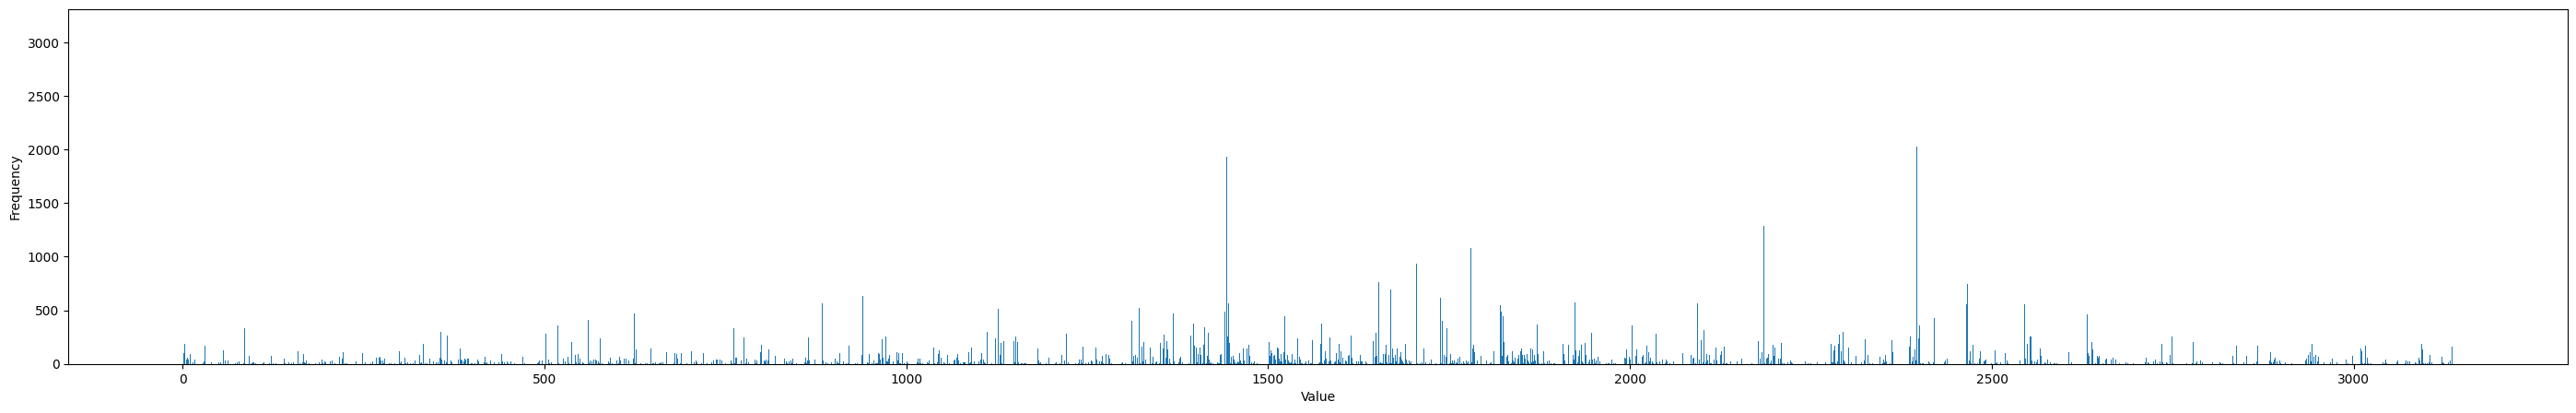

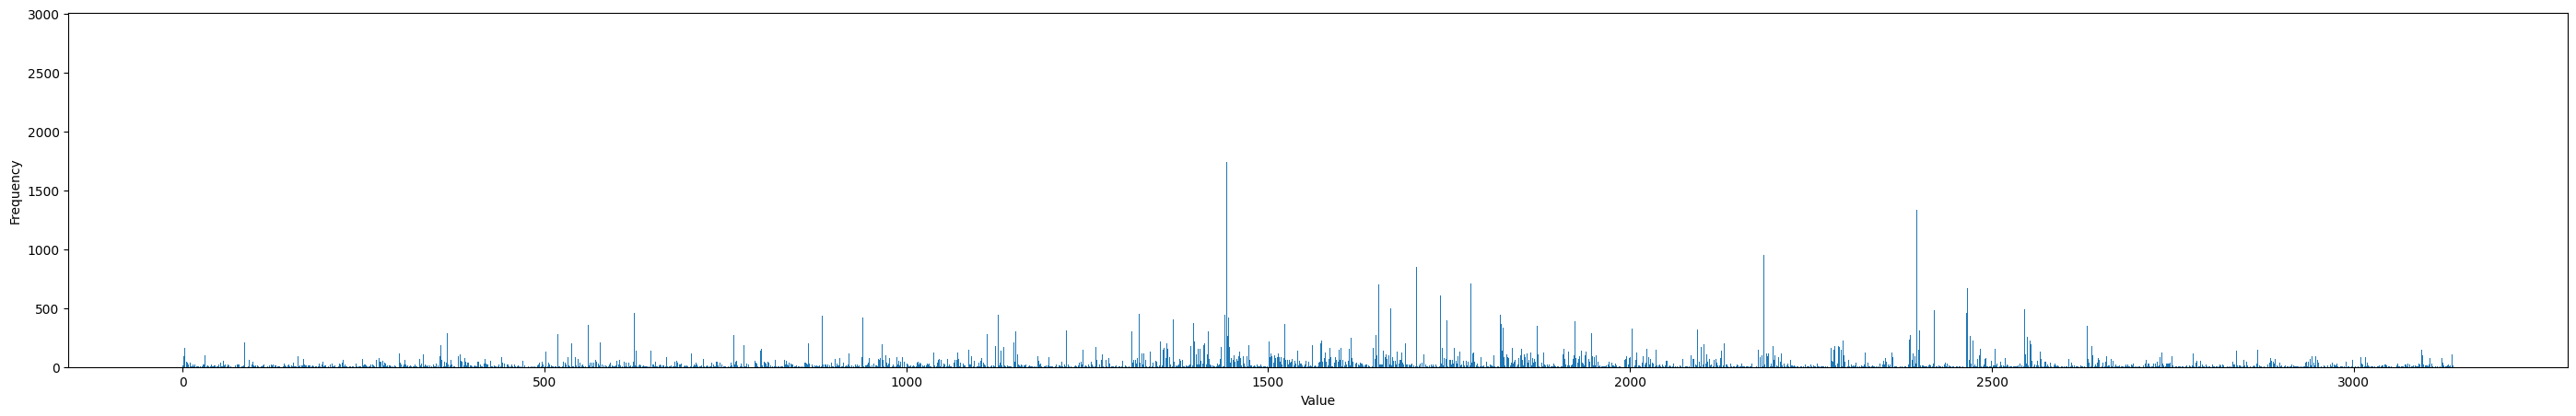

Val Loss: 1.4920 Acc: 0.5318 Score: 4306.3822


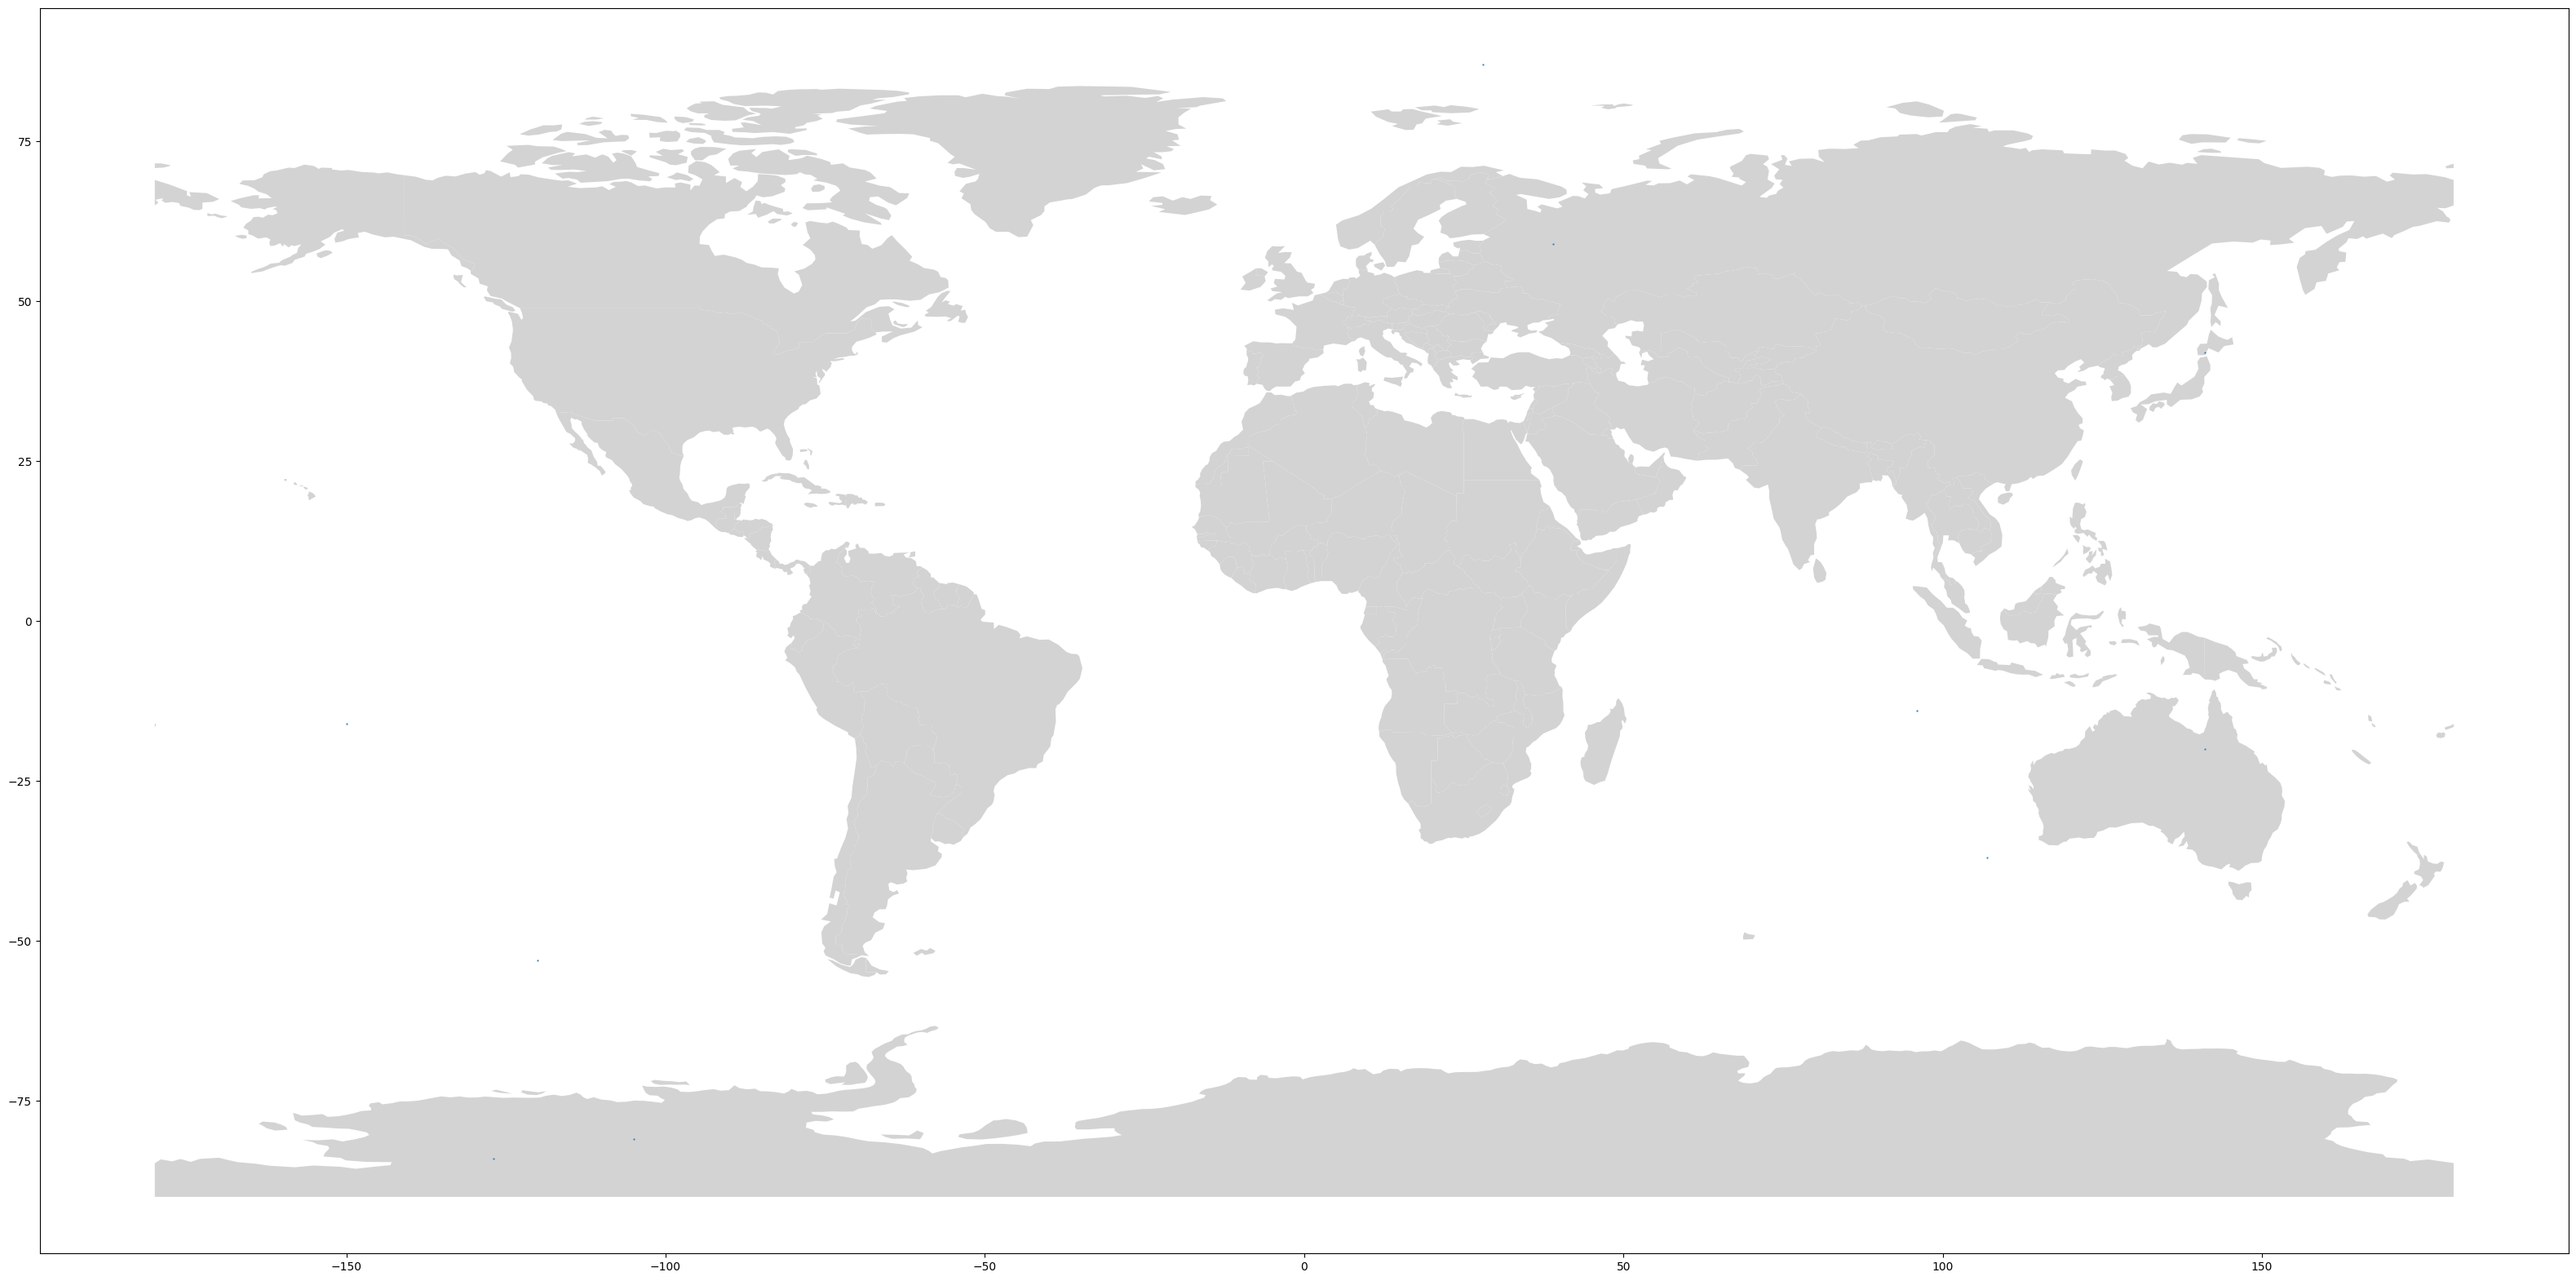

In [16]:
geogussr_score(model_ft)

In [17]:
a = np.arange(64000)
vis = []
for i in range(len(a)):
    vis.append(geohash_to_lat_lon(decimal_to_geohash(a[i])))
vis = np.array(vis)

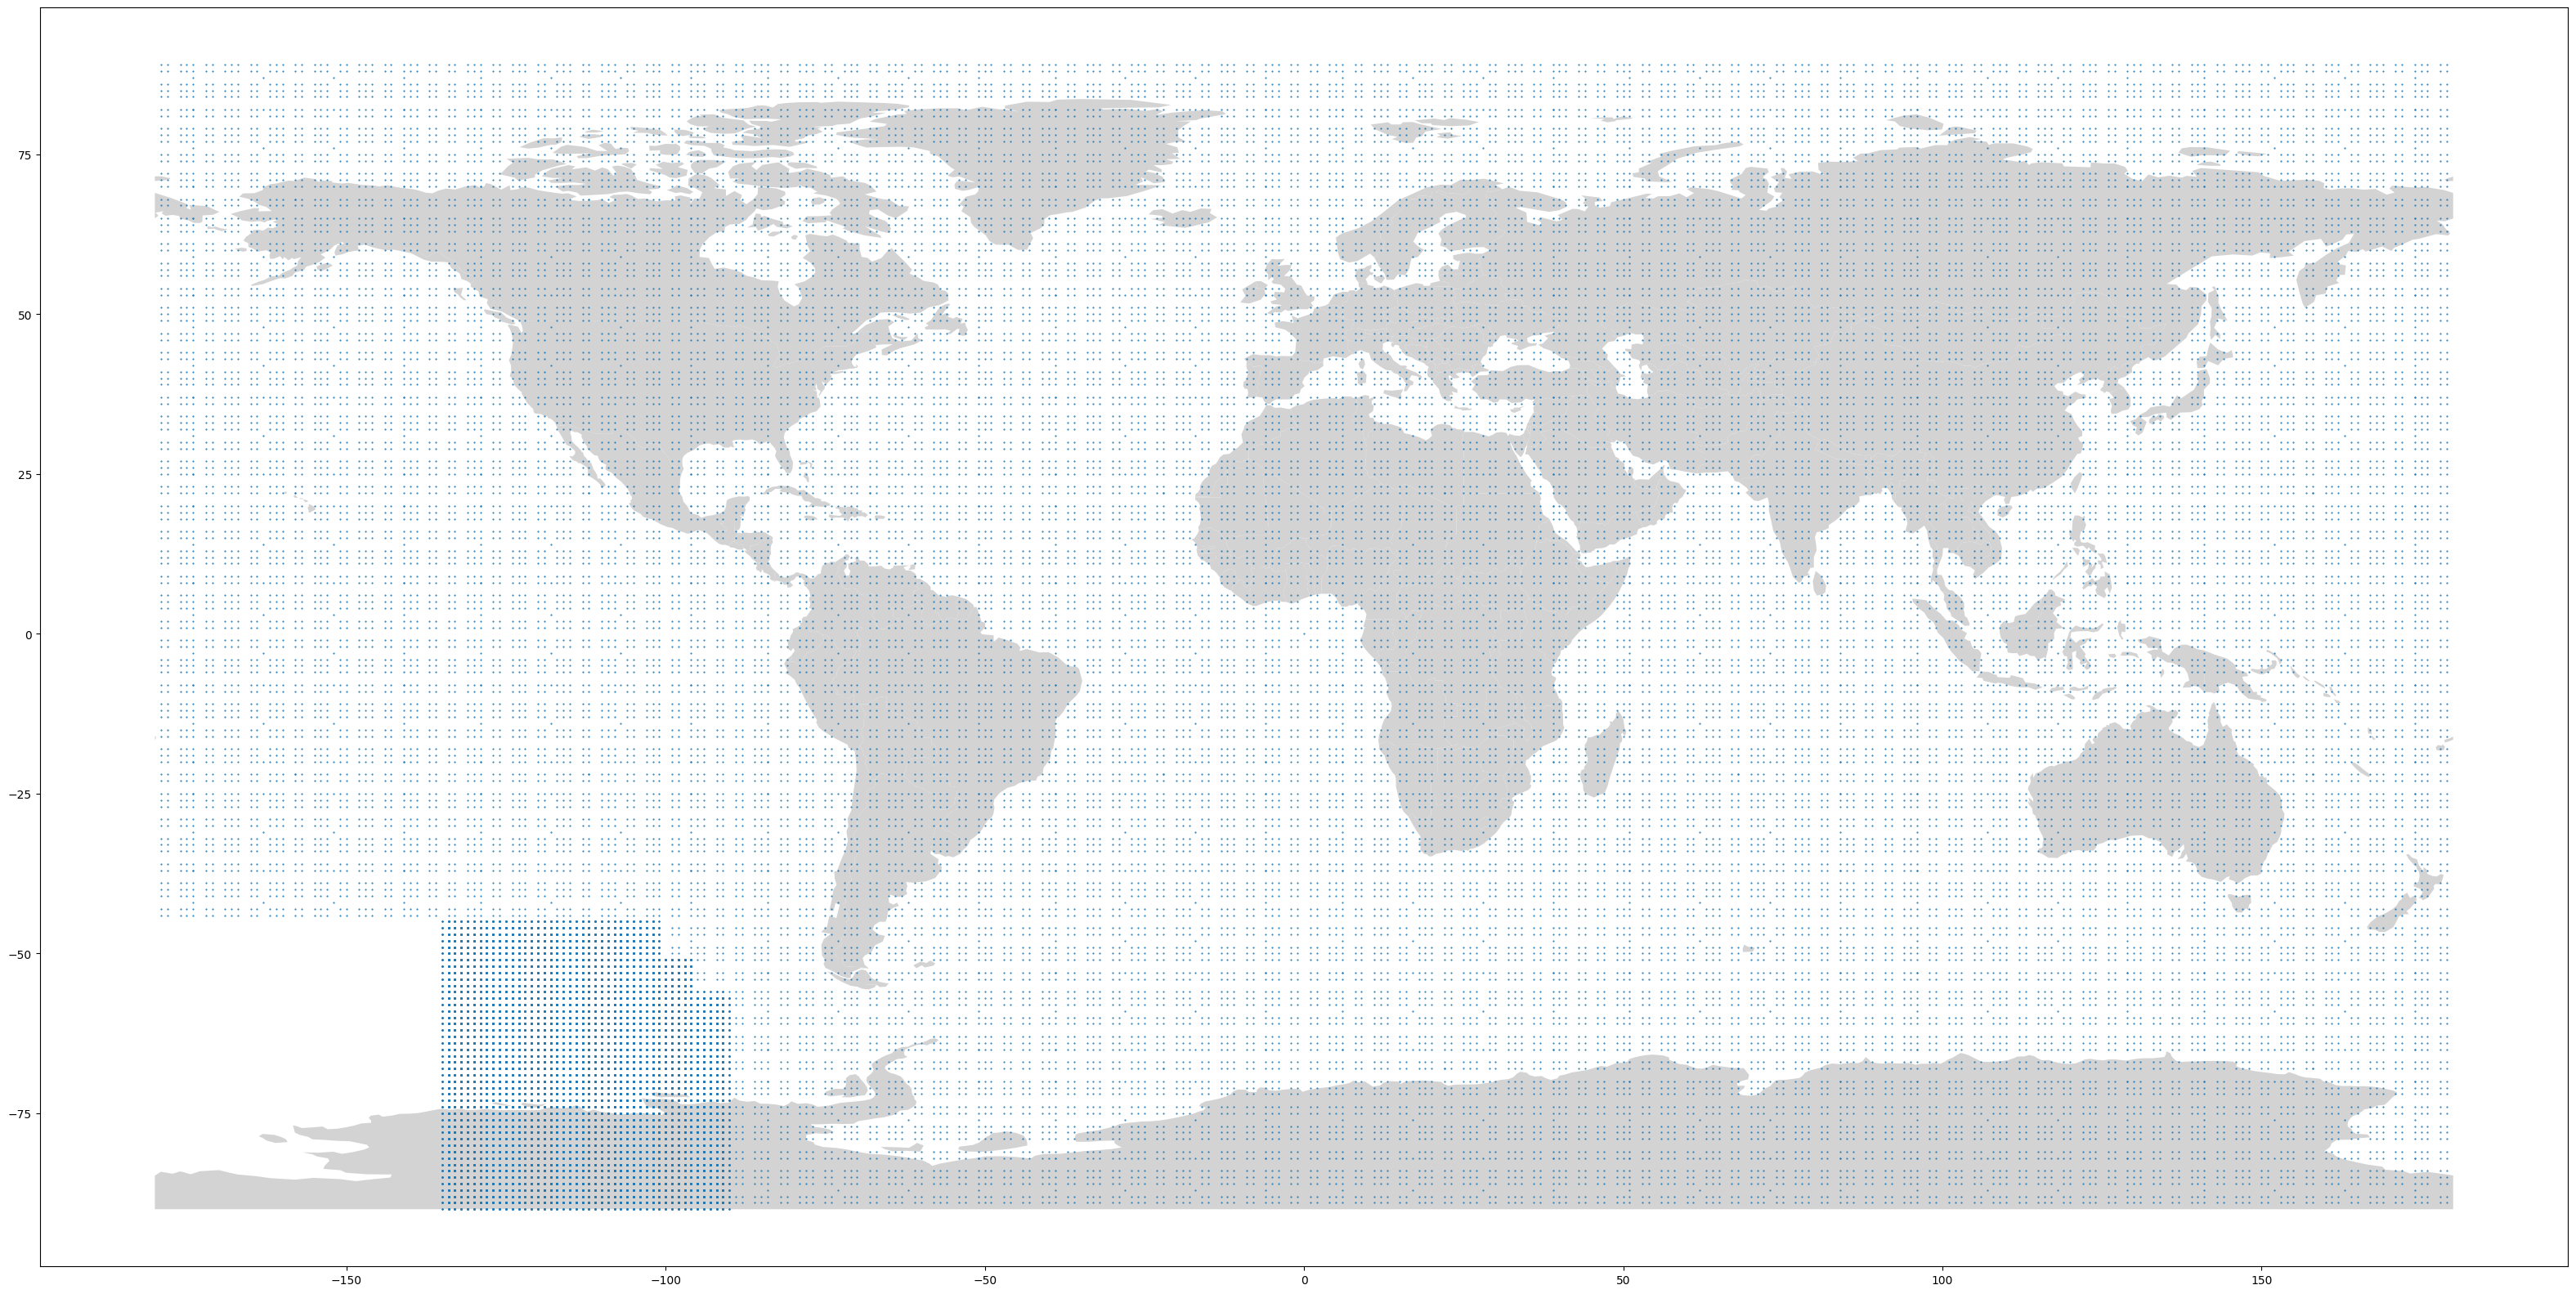

In [18]:
import geopandas as gpd

countries = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))
lab_for_plot = vis.copy()

countries.plot(color="lightgrey", figsize = (40, 20))


plt.scatter(vis[:,1], vis[:,0], s = 0.3)
plt.show()

In [19]:
x = torch.load('mappredtohash.pt')
vis = []
for i in range(len(x)):
    vis.append(geohash_to_lat_lon(decimal_to_geohash(x[i])))
vis = np.array(vis)

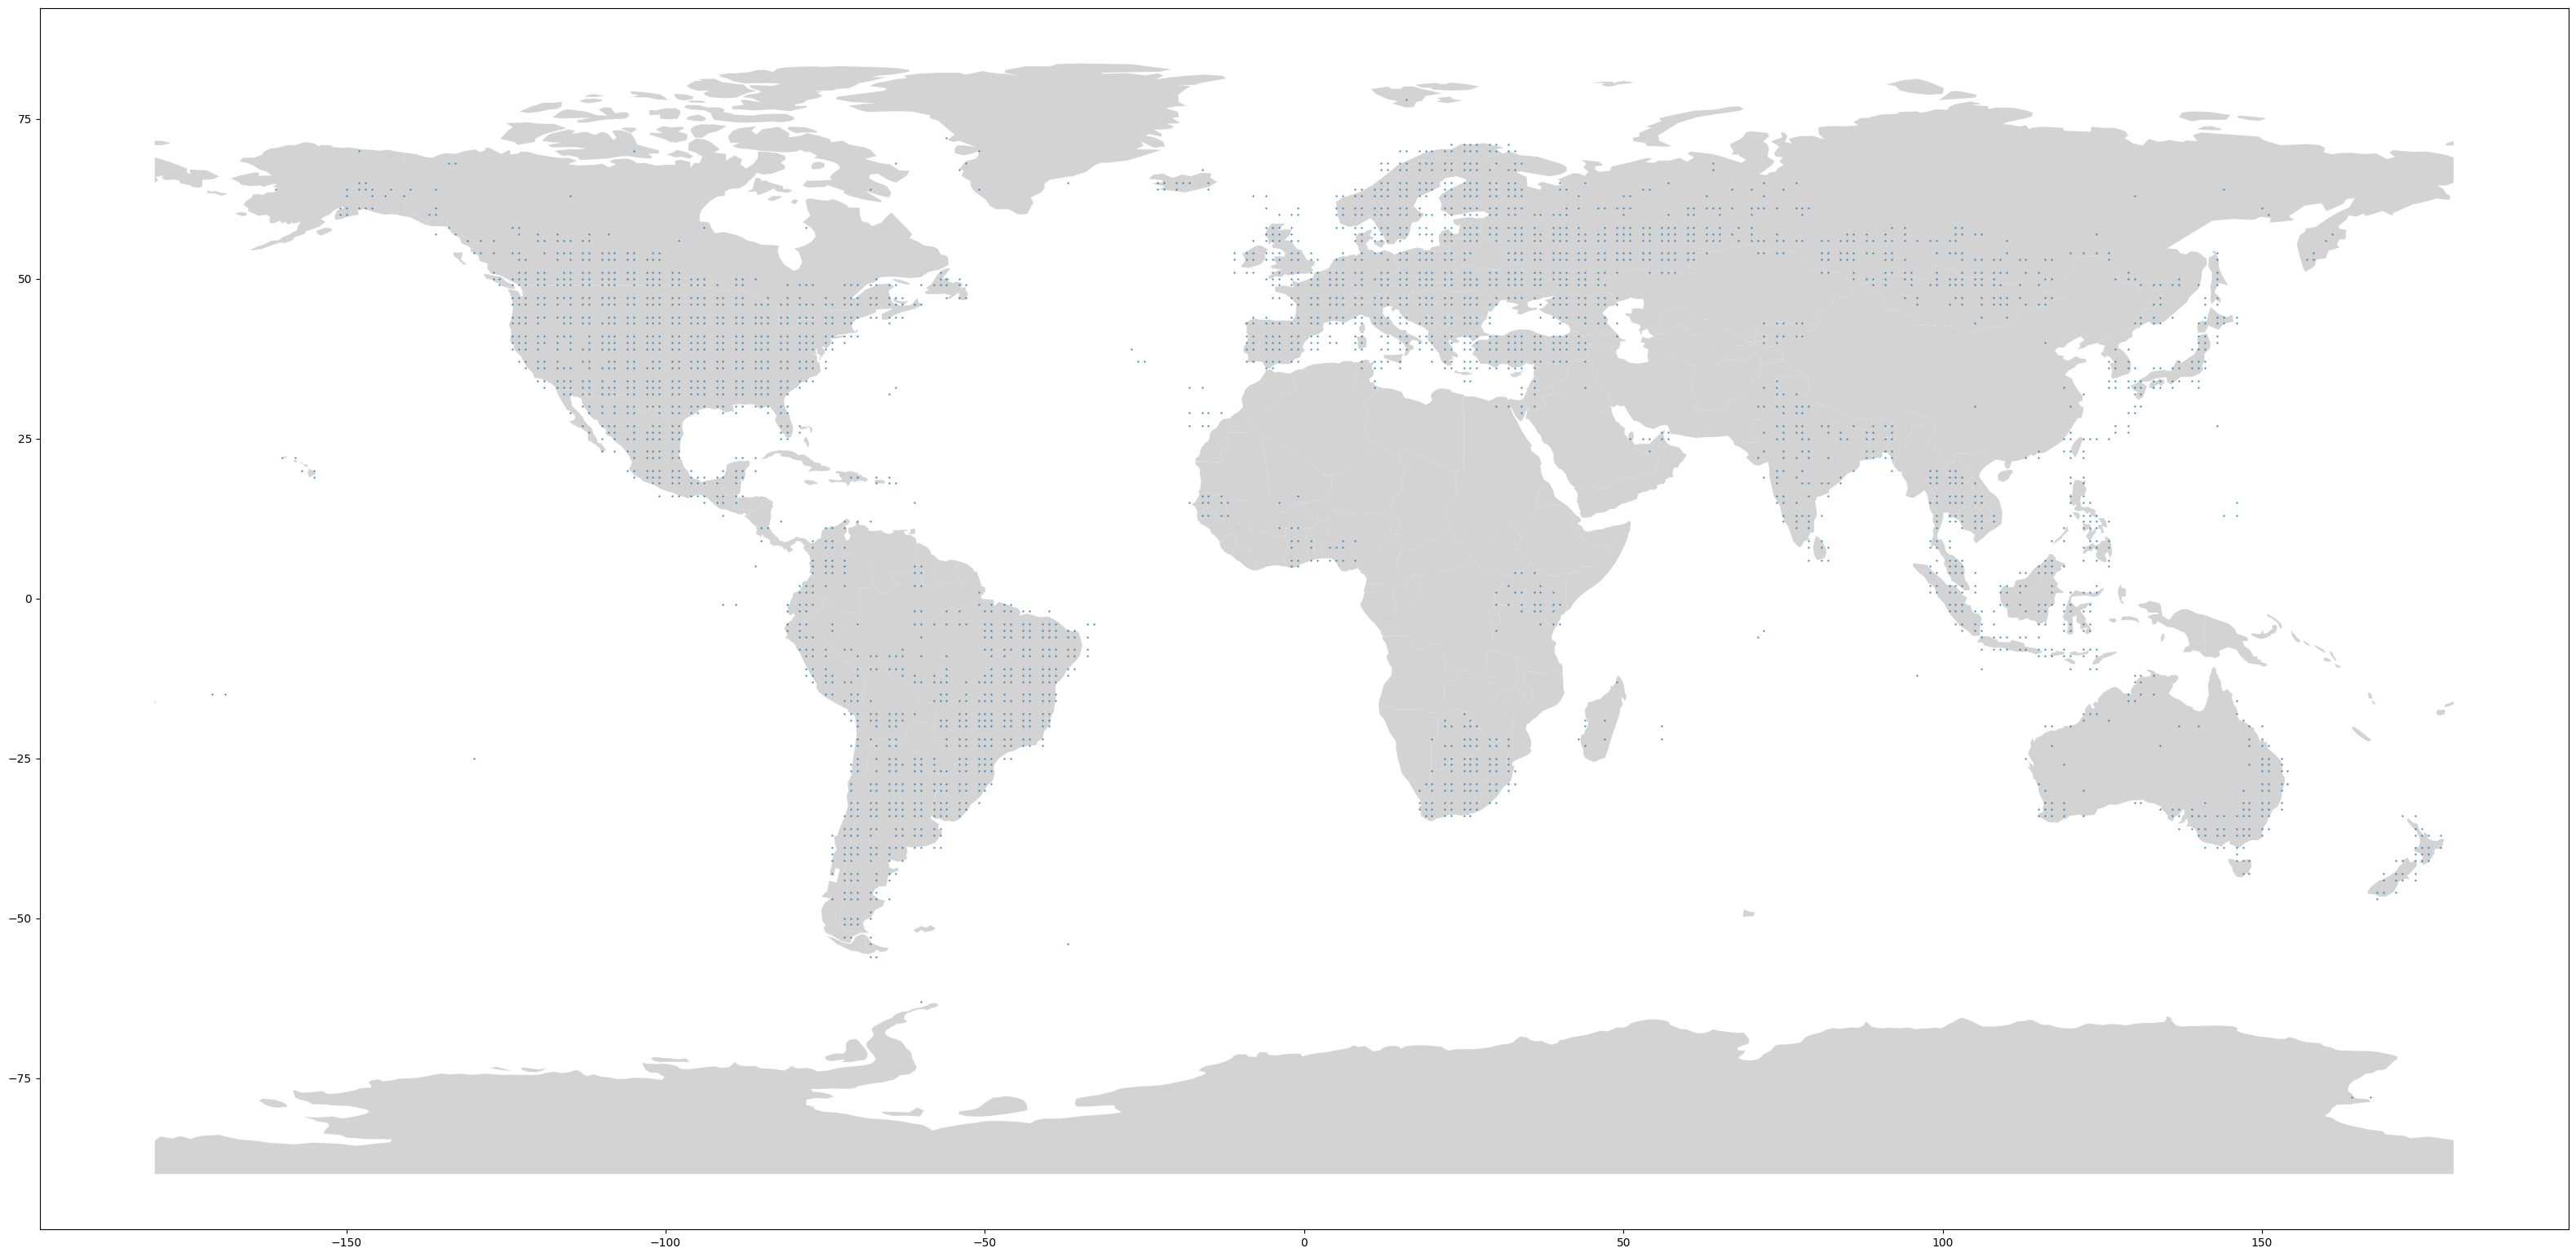

In [20]:
import geopandas as gpd

countries = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))
lab_for_plot = vis.copy()

countries.plot(color="lightgrey", figsize = (40, 40))


plt.scatter(vis[:,1], vis[:,0], s = 0.3)
plt.show()